<div style="text-align: center; font-family: Arial, sans-serif;">
    <h1 style="font-size: 30px; color: #2196F3;">ALY 6020 : Predictive Analytics</h1>
    <h3 style="font-size: 16px; color: #9C27B0;">Prof. Sudesh Shetty</h3>
    <h3 style="font-size: 16px; color: #9C27B0;">Final Project</h3>
    <h3 style="font-size: 16px; color: #9C27B0;">Topic: Predicting Vehicle Loan Default for a Non-Banking Financial Institution</h3>
    <h3 style="font-size: 14px; color: #9C27B0;">Date: 5th February 2025</h3>
</div>

## Problem Statement:

A non-banking financial institution (NBFI) is experiencing financial losses due to an increasing number of defaults in its vehicle loan portfolio. To mitigate this risk, the company seeks to develop a predictive model that assesses a client's ability to repay loans. By leveraging historical data, the model will help identify high-risk clients and enable data-driven credit decision-making.

## Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
import pyodbc
print(pyodbc.drivers())
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from scipy import stats

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


## SQL Connection

In [2]:
def create_sql_connection(server, database, username, password, driver='{ODBC Driver 17 for SQL Server}'):
    """
    Establish a connection to a SQL Server database using pyodbc.

    Parameters:
    - server (str): The SQL Server address (e.g., 'localhost' or server IP).
    - database (str): The name of the database you want to connect to.
    - username (str): SQL Server username.
    - password (str): SQL Server password.
    - driver (str): ODBC driver to use. Default is '{ODBC Driver 17 for SQL Server}'.s

    Returns:
    - conn: A pyodbc connection object if successful.
    """
    connection_string = f"""
        DRIVER={driver};
        SERVER={server};
        DATABASE={database};
        UID={username};
        PWD={password};
    """
    try:
        conn = pyodbc.connect(connection_string)
        print("Connection established successfully!")
        return conn
    except Exception as e:
        print(f"Failed to connect to the database. Error: {e}")
        return None

In [3]:
def query_data(conn, query):
    """
    Execute a SQL query and fetch results as a pandas DataFrame.
    
    Parameters:
    - conn: A pyodbc connection object.
    - query (str): The SQL query to be executed.
    
    Returns:
    - data: A pandas DataFrame containing the query result.
    """
    start_time = time.time()  # Start time measurement
    try:
        cursor = conn.cursor()
        cursor.execute(query)
        
        # Fetch all results from the query
        rows = cursor.fetchall()
        
        # Get column names from cursor
        columns = [desc[0] for desc in cursor.description]
        
        # Create a pandas DataFrame from the results
        data = pd.DataFrame.from_records(rows, columns=columns)
        
    except pyodbc.Error as e:
        print(f"Error executing query: {e}")
        return None
    
    finally:
        cursor.close()
    
    end_time = time.time()  # End time measurement
    execution_time = end_time - start_time  # Calculate execution time
    
    # Print the DataFrame and execution time
    print(f"Query executed in: {execution_time:.4f} seconds")
    
    return data  

In [4]:
server = 'ROHIT'     
database = 'NBFIData'  
username = 'rohit_kosamkar'       
password = 'February@2025' 

# Establish connection
conn = create_sql_connection(server, database, username, password)

Connection established successfully!


## Loading Dataset

In [5]:
query = """
select * from dbo.customers as cust
left join dbo.defaulters as def on cust.ID = def.ID
"""

In [6]:
data_temp = query_data(conn, query)
data_temp.shape

Query executed in: 1.8215 seconds


(121856, 41)

In [7]:
data_temp = pd.read_csv(r"D:\mps_analytics\q4\ALY6020\final_project_rk\data\Train_Dataset.csv")

C:\Users\rohit\AppData\Local\Temp\ipykernel_9932\2603120444.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_temp = pd.read_csv(r"D:\mps_analytics\q4\ALY6020\final_project_rk\data\Train_Dataset.csv")


In [8]:
data = data_temp.copy(deep=True)
data.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750.0,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,NaN,1,1,0,Sales,2.0,2.0,6.0,17.0,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250.0,1.0,0.0,1.0,NaN,0.0,15282.00,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,0.0,1,0,1,NaN,2.0,2.0,3.0,10.0,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000.0,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,16790.0,5102.0,NaN,331.0,NaN,1,0,0,Realty agents,2.0,2.0,4.0,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0
3,12188929,15750.0,0.0,0.0,1.0,1.0,0.0,53870.40,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195.0,365243.0,NaN,775.0,NaN,1,0,0,NaN,2.0,3.0,2.0,15.0,Yes,Yes,XNA,NaN,0.135182,0.631355,NaN,1700.0,3.0,0
4,12133385,33750.0,1.0,0.0,1.0,0.0,2.0,133988.40,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366.0,2977.0,5516.0,4043.0,6.0,1,0,0,Laborers,4.0,1.0,3.0,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0


In [9]:
data.describe()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
count,1.218070e+05,1.182010e+05,118226.000000,118183.000000,118174.000000,118148.000000,118171.000000,118176.000000,116950.000000,118207.000000,118158.000000,118193.000000,115841.000000,41746.000000,121807.000000,121807.000000,121807.000000,119398.000000,119403.000000,119379.000000,118146.000000,53004.000000,116122.000000,94894.000000,59908.000000,118145.000000,103271.000000,121807.000000
mean,1.216093e+07,1.686560e+04,0.342860,0.332298,0.499188,0.692073,0.417835,60046.500845,0.022602,16027.409113,67150.066208,4975.390996,2987.499555,12.154362,0.999992,0.200506,0.281199,2.154416,2.030049,3.159593,12.063100,0.501230,0.518630,0.511202,0.117426,962.136265,1.891189,0.080800
std,3.517782e+04,1.153891e+04,0.474667,0.471039,0.500001,0.461638,0.728864,40351.430165,0.413684,4366.228272,138968.488833,3514.744457,1511.888805,12.051772,0.002865,0.400380,0.449586,0.912717,0.504417,1.759029,3.280595,0.211213,0.740391,0.194318,0.107981,827.946180,1.861971,0.272529
min,1.210000e+07,2.565000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,0.000533,7676.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.014568,0.000005,0.000527,0.000000,0.000000,0.000000,0.000000
25%,1.213046e+07,1.125000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,27000.000000,0.010006,12398.000000,932.000000,2008.000000,1705.000000,5.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.333507,0.390186,0.372334,0.057700,272.000000,0.000000,0.000000
50%,1.216092e+07,1.440000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,51750.000000,0.018850,15734.000000,2212.000000,4493.000000,3242.000000,9.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,12.000000,0.504785,0.564989,0.537070,0.088700,755.000000,1.000000,0.000000
75%,1.219139e+07,2.025000e+04,1.000000,1.000000,1.000000,1.000000,1.000000,80865.000000,0.028663,19661.000000,5634.000000,7464.000000,4295.000000,15.000000,1.000000,0.000000,1.000000,3.000000,2.000000,5.000000,14.000000,0.673891,0.663998,0.667458,0.148500,1570.000000,3.000000,0.000000
max,1.222186e+07,1.800009e+06,1.000000,1.000000,1.000000,1.000000,19.000000,405000.000000,100.000000,25201.000000,365243.000000,23738.000000,7197.000000,69.000000,1.000000,1.000000,1.000000,16.000000,3.000000,6.000000,23.000000,0.945741,100.000000,0.896010,1.000000,4185.000000,22.000000,1.000000


## 1. Cleaning Data

In [10]:
data.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Population_Region_Relative', 'Age_Days',
       'Employed_Days', 'Registration_Days', 'ID_Days', 'Own_House_Age',
       'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Client_Occupation',
       'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Type_Organization', 'Score_Source_1', 'Score_Source_2',
       'Score_Source_3', 'Social_Circle_Default', 'Phone_Change',
       'Credit_Bureau', 'Default'],
      dtype='object')

### 1.1 Duplicates Check

In [11]:
data.duplicated().sum()

0

### 1.2 Missing Value Check

In [12]:
data['Default'].value_counts()

Default
0    111965
1      9842
Name: count, dtype: int64

In [13]:
# Calculate missing value percentage
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Display the result
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print(missing_percentage)

Own_House_Age                 65.727750
Score_Source_1                56.485259
Social_Circle_Default         50.817277
Client_Occupation             34.002151
Score_Source_3                22.094789
Credit_Bureau                 15.217516
ID_Days                        4.897912
Score_Source_2                 4.667219
Population_Region_Relative     3.987456
Loan_Annuity                   3.949691
Client_Income_Type             3.036771
Client_Housing_Type            3.026920
Phone_Change                   3.006395
Application_Process_Hour       3.005574
House_Own                      3.003932
Loan_Contract_Type             2.995723
Employed_Days                  2.995723
Client_Education               2.990797
Child_Count                    2.985050
Active_Loan                    2.982587
Credit_Amount                  2.980945
Bike_Owned                     2.975198
Registration_Days              2.966989
Type_Organization              2.961242
Client_Income                  2.960421


Dropping Columns with More Than 30% Missing Values.
- Own_House_Age (65.73%)
- Score_Source_1 (56.49%)
- Social_Circle_Default (50.82%)
- Client_Occupation (34%
)

In [14]:
data.drop(columns={'Own_House_Age', 'Score_Source_1', 'Social_Circle_Default', 'Client_Occupation'}, inplace=True)
data.shape


(121807, 36)

#### 1.2.1 Missing Value Treatment

In [15]:
cols_to_num = ['Client_Income', 'Credit_Amount', 'Age_Days', 'Employed_Days',
       'Registration_Days', "Population_Region_Relative"]
data[cols_to_num] = data[cols_to_num].apply(lambda x: x.astype('float'))

In [16]:
data['Loan_Annuity'] = (
    data['Loan_Annuity']
    .str.replace(r'[^\d.-]', '1111111', regex=True)  # Keep only numbers, decimals, and negatives and replacing it with unique value later we'll impute nan and then mean
    .astype('float')
)

In [17]:
data['Loan_Annuity'].replace(1111111, np.nan, inplace=True)

In [18]:
# Numerical columns -> Filling with the median value
num_cols = data.select_dtypes(include=['int', 'float']).columns
num_cols

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Population_Region_Relative', 'Age_Days', 'Employed_Days',
       'Registration_Days', 'ID_Days', 'Mobile_Tag', 'Homephone_Tag',
       'Workphone_Working', 'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour', 'Score_Source_2',
       'Score_Source_3', 'Phone_Change', 'Credit_Bureau', 'Default'],
      dtype='object')

In [19]:
# Let's impute missing values in numerical columns with median
columns_to_clean = ["ID_Days", "Score_Source_3","Credit_Bureau", "Loan_Annuity", "Population_Region_Relative"]
data[columns_to_clean] = data[columns_to_clean].apply(lambda x: x.fillna(x.median()))

In [20]:
data[["ID_Days", "Score_Source_3", "Credit_Bureau", "Loan_Annuity", "Population_Region_Relative"]].head() 

,ID_Days,Score_Source_3,Credit_Bureau,Loan_Annuity,Population_Region_Relative
0,383.0,0.537070,1.0,3416.85,0.028663
1,21.0,0.537070,1.0,1826.55,0.008575
2,331.0,0.329655,0.0,2788.20,0.022800
3,775.0,0.631355,3.0,2295.45,0.010556
4,4043.0,0.355639,1.0,3547.35,0.020713


In [21]:
# Rest all missing values we will drop as most of the columns contains ~3% missing values
data.dropna(inplace=True)

In [24]:
# data.isna().sum()

### 1.3 Outlier Check

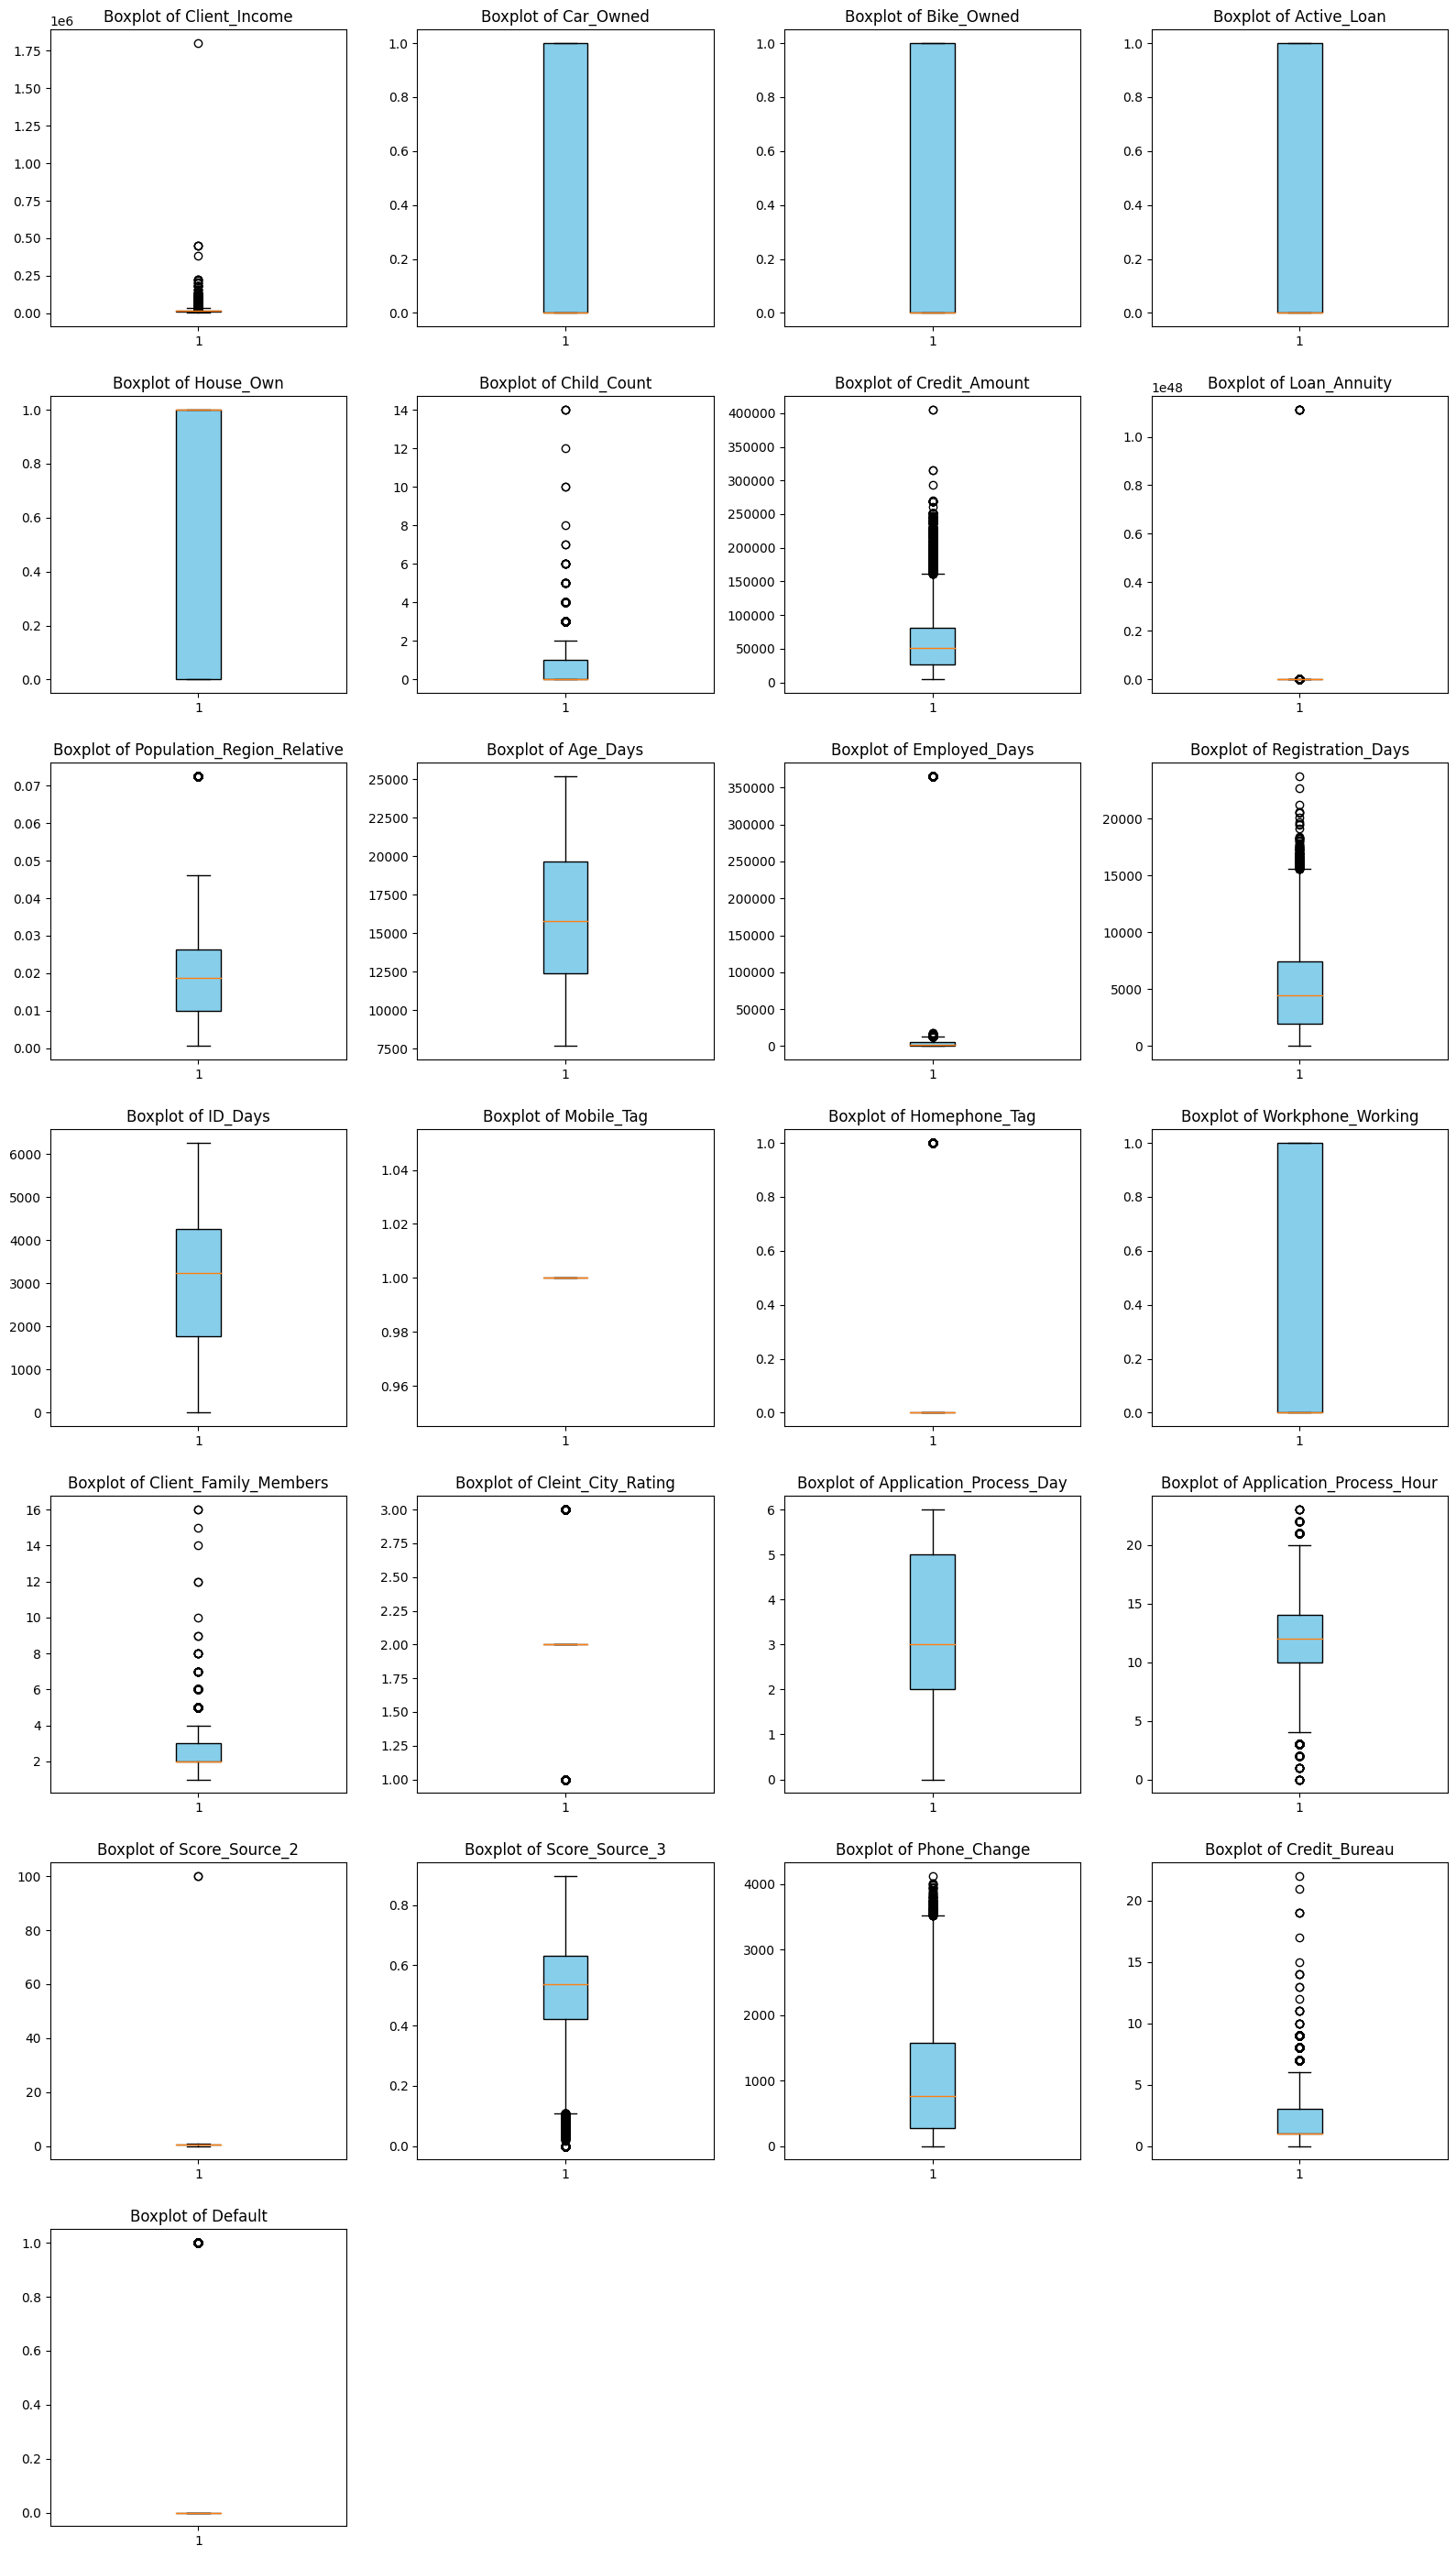

In [25]:
# Identify numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns[1:]  # Exclude 'ID' column
numeric_data = data[numeric_cols]  # Subset numeric data

# Set up the grid layout for multiple boxplots
num_cols = len(numeric_cols)
rows = (num_cols // 4) + (num_cols % 4 > 0)  # Arrange in 4 columns

plt.figure(figsize=(16, rows * 4))  # Adjust figure size dynamically

# Plot boxplots for each numeric variable
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 4, i)  # Define subplot grid
    plt.boxplot(numeric_data[col].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {col}")

plt.tight_layout()  # Adjust layout for better visualization
plt.show()

Variables with Outliers:

- Client_Income: Significant outliers with very high values, indicating income inequality among clients.
- Credit_Amount: Wide range with outliers representing large loan requests.
- Loan_Annuity: A few extreme values, likely due to incorrect or edge-case entries.
- Registration_Days: Outliers representing unusual registration timing.
- Phone_Change: Outliers indicate clients changing phones either very recently or a long time ago.

Other Variables:

- Most variables (e.g., Car_Owned, Child_Count, Application_Process_Hour) have small ranges or are binary/discrete, so outliers aren't impactful or meaningful for treatment.

In [26]:
def treat_outliers_iqr(df, column):
    """
    Treat outliers in a specified column using the IQR method.
    Values outside the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR] are capped.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The column name to treat outliers.
    
    Returns:
        pd.Series: The column with outliers capped.
    """
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    return df[column].apply(
        lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
    )

In [27]:
# Columns to treat
columns_to_treat = ["Client_Income", "Credit_Amount", "Loan_Annuity", "Registration_Days", "Phone_Change"]

# Apply IQR-based outlier treatment
for col in columns_to_treat:
    data[col] = treat_outliers_iqr(data, col)

## 2. Exploratory Data Analysis (EDA)

### 2.1 Univariate Analysis

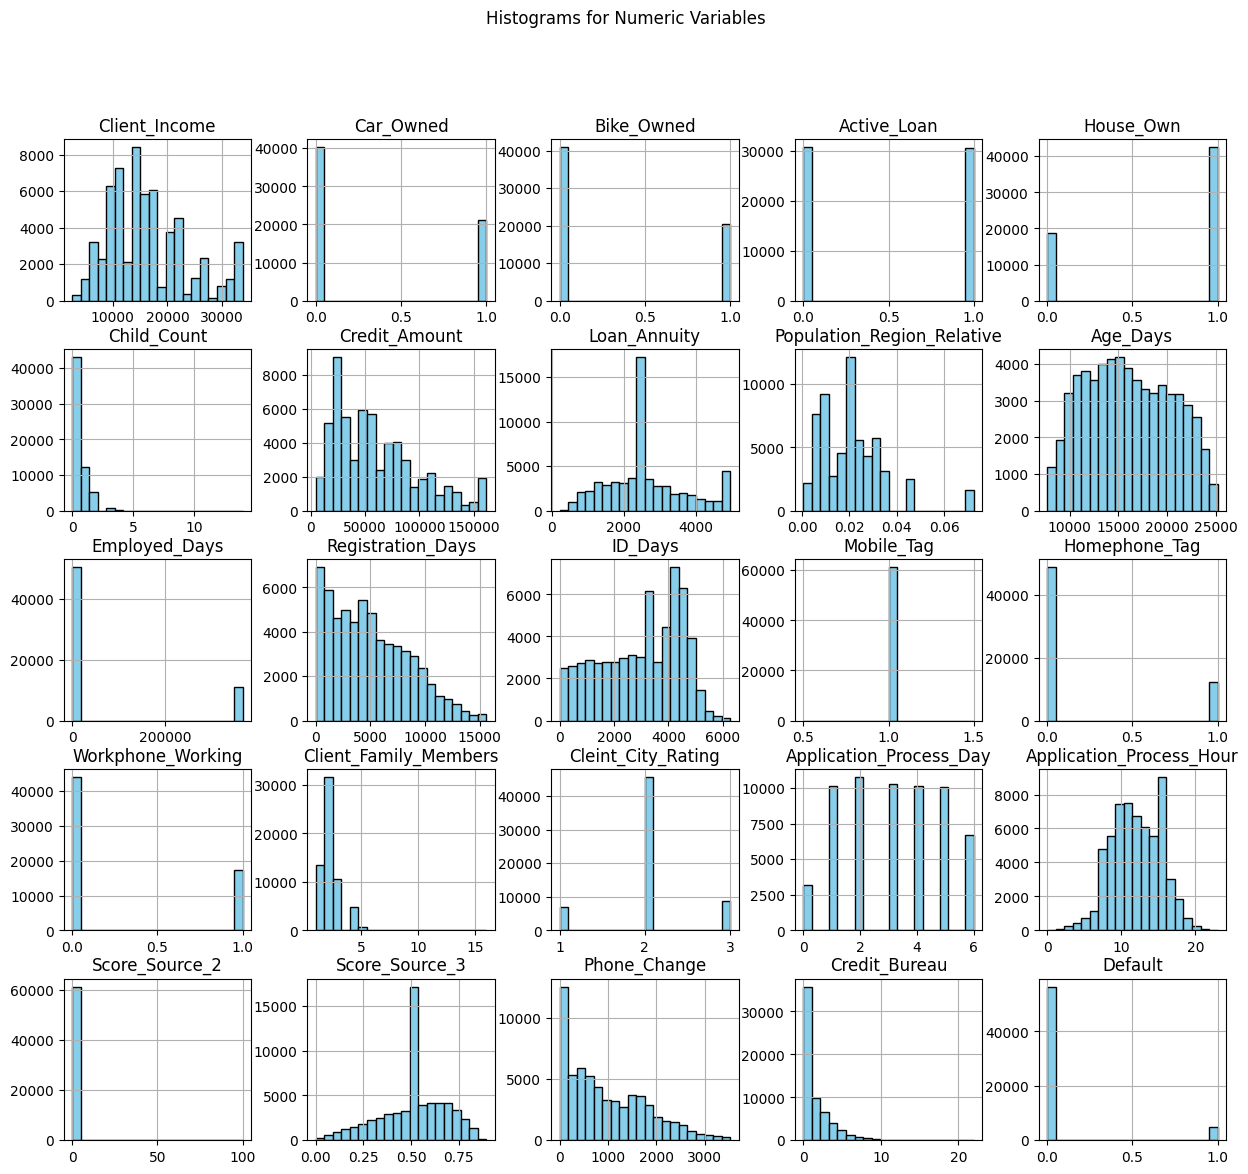

In [28]:
# Plot histograms for numeric variables
data[numeric_cols].hist(figsize=(15, 13), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Histograms for Numeric Variables")
plt.show()

In [33]:
categorical_cols = data.select_dtypes(include=['object']).columns[:-1]  # Exclude 'Type_Organization' column which has lot of categories
categorical_cols

Index(['Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Client_Permanent_Match_Tag',
       'Client_Contact_Work_Tag'],
      dtype='object')

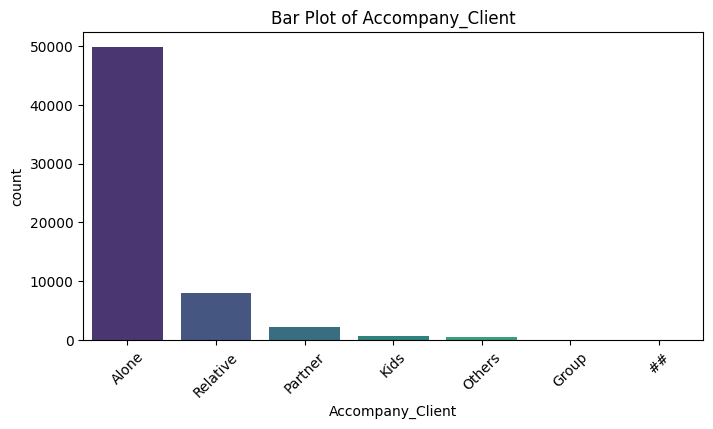

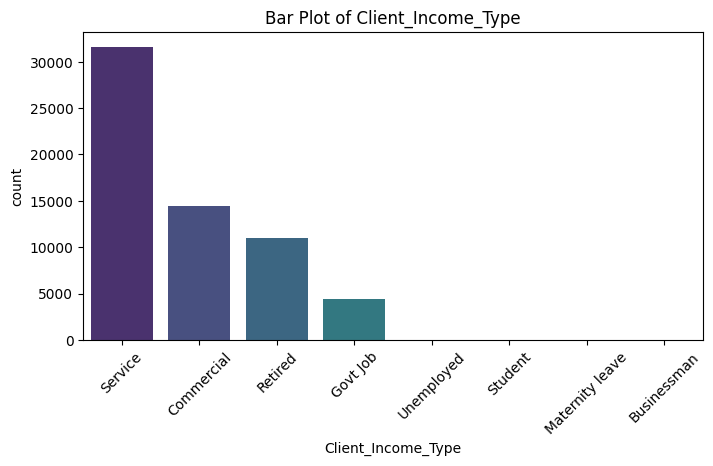

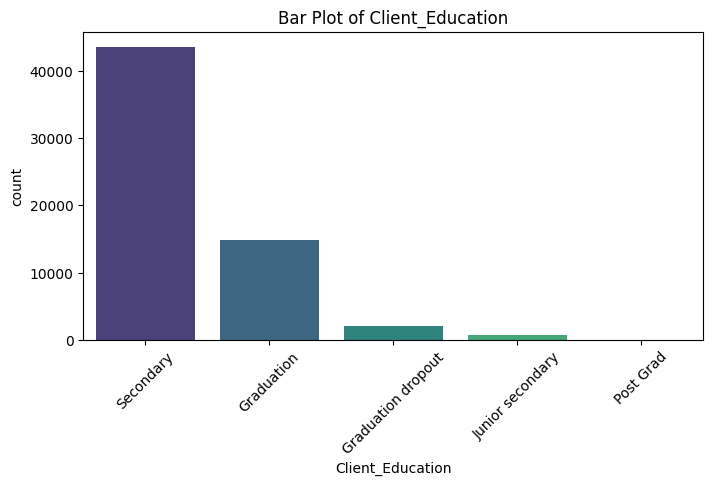

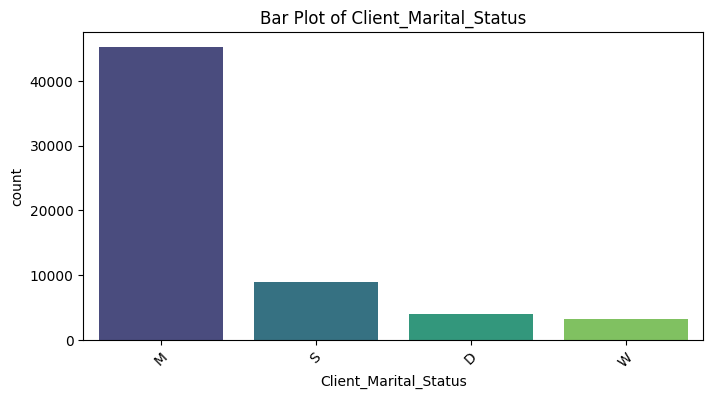

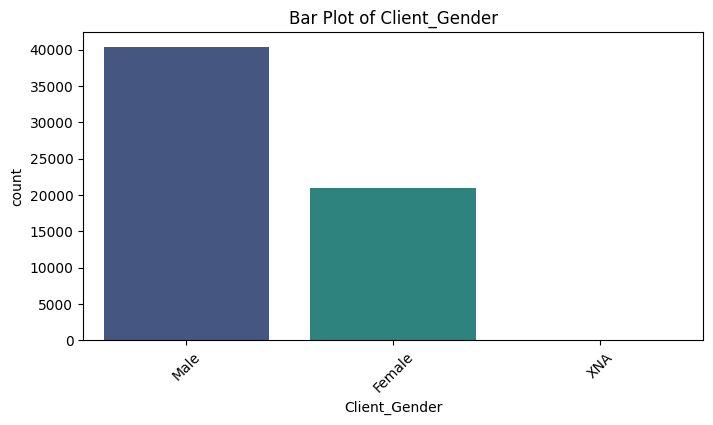

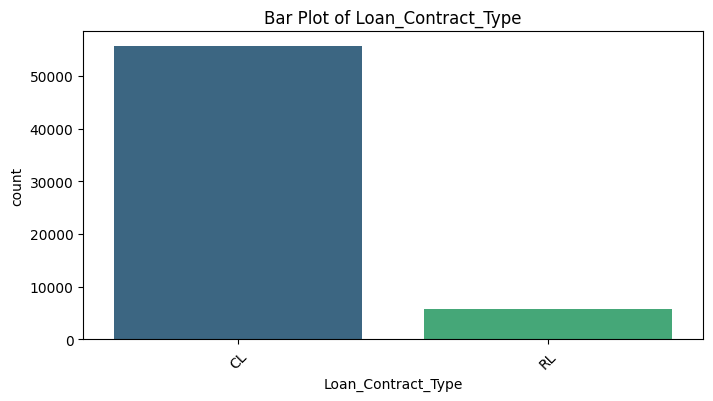

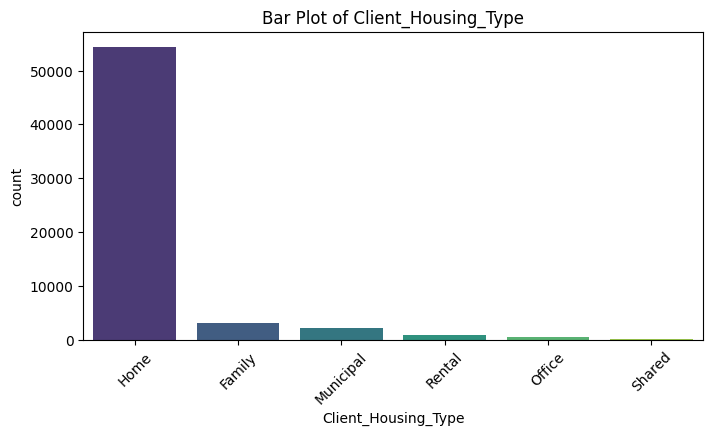

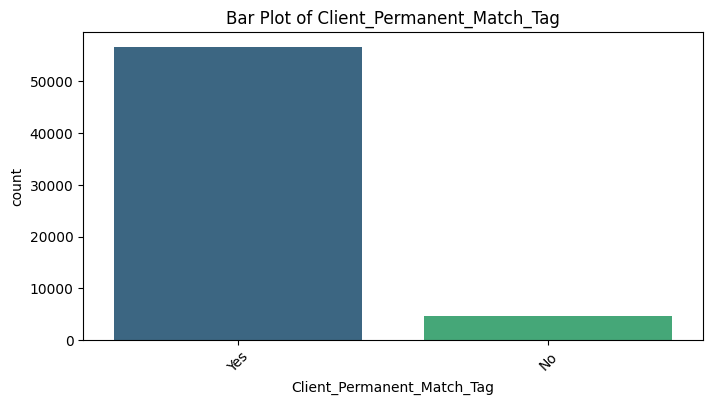

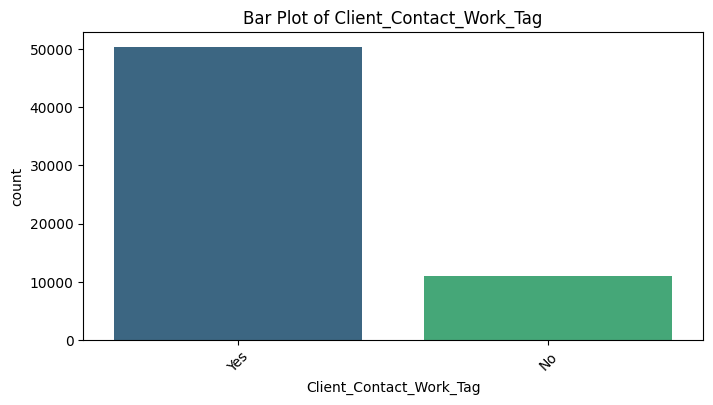

In [34]:
# Bar plots for categorical variables
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col, palette="viridis", order=data[col].value_counts().index)
    plt.title(f"Bar Plot of {col}")
    plt.xticks(rotation=45)
    plt.show()